## Lecture 3: Reliability



In [1]:
import os
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import json
from scipy import stats
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

## Reliability: Data as a model of itself

Here we will use data from the Self Regulation Ontology (SRO) project to assess reliability.  We will focus on one particular measure, the Barratt Impulsiveness Scale, which has a total of 30 items.

### Test-retest reliability

First we will look at data from the 150 subjects who performed the entire battery twice.  The correlation between the scores on each of the sessions is known as *test-retest reliability* and is the most common way to assess reliability in psychology.


In [2]:
SRO_datadir = 'data/SRO'

SRO_origdata = pd.read_csv(
    os.path.join(SRO_datadir, 'orig_subjects_x_items.csv'),
    index_col=0)
SRO_retestdata = pd.read_csv(
    os.path.join(SRO_datadir, 'retest_subjects_x_items.csv'),
    index_col=0)

# combine orig and retest data
# original variables will have suffix _orig, retest variables have _retest

SROdata = SRO_origdata.join(SRO_retestdata, lsuffix='_orig', rsuffix='_retest')

# extract BIS-11 survey variables

BISdata = SROdata[[col for col in SROdata.columns if 'bis11_survey' in col]]
print(BISdata.shape)


(522, 60)


In [3]:
# compute total scores for each measure

BISdata.loc[:, 'mean_test1'] = BISdata[[col for col in BISdata if '_orig' in col]].mean(1)
BISdata.loc[:, 'mean_test2'] = BISdata[[col for col in BISdata if '_retest' in col]].mean(1)

# subjects who did not perform retest have NA for the missing variables
# we can subset just the retest subjects by dropping all rows with NA values

BISdata_test_retest = BISdata.dropna()
BISdata_test_retest.shape

/Users/poldrack/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/poldrack/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1046: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


(150, 62)

Text(0, 0.5, 'BIS11 Overall - Retest score')

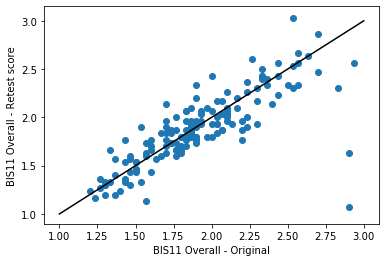

In [4]:
# create a scatter plot for test vs retest data
plt.scatter(BISdata_test_retest['mean_test1'], 
            BISdata_test_retest['mean_test2'])
plt.plot([1, 3], [1, 3], color='black')
plt.xlabel('BIS11 Overall - Original')
plt.ylabel('BIS11 Overall - Retest score')


There are clearly a couple of outliers here, but in general the scores seem fairly consistent between the two tests. We can quantify this using the Pearson correlation:

In [5]:
#retest_reliability = np.corrcoef(BISdata_test_retest['mean_test1'], BISdata_test_retest['mean_test2'])[0, 1]im

import scipy.stats
scipy.stats.spearmanr(BISdata_test_retest['mean_test1'], BISdata_test_retest['mean_test2'])
#retest_reliability

SpearmanrResult(correlation=0.8258583305175007, pvalue=1.1835708795040622e-38)

### Split-half reliability

In the previous case, we had two overall scores for each individual.  However, those two scores were based on responses over a set of 30 total items.  Another way to assess reliability would be to randomly split those items into half, and look at the correlation between the two splits.

In order to make the dataset clearer, we will load the actual text for each of the items (which are stored in a metadata file in the JSON format), and use those as variable names in the data frame.

In [6]:
# set up the item level data for BIS-11 in the original sample

BIS11_itemdata = SRO_origdata[[col for col in SRO_origdata.columns if 'bis11_survey' in col]].dropna()
print(BIS11_itemdata.shape)

## first load item metadata
with open(os.path.join(SRO_datadir, 'bis11_survey.json')) as f:
    bis11_metadata = json.load(f)

# make metadata dict for column names
bis11_itemdict = {}
for i in bis11_metadata:
    if 'bis11' not in i:
        continue
    colname_split = i.split('survey_')
    colname = 'bis11_survey.%02.f' % (int(colname_split[1]))
    
    bis11_itemdict[colname] = bis11_metadata[i]['Description']

BIS11_itemdata = BIS11_itemdata.rename(columns=bis11_itemdict)

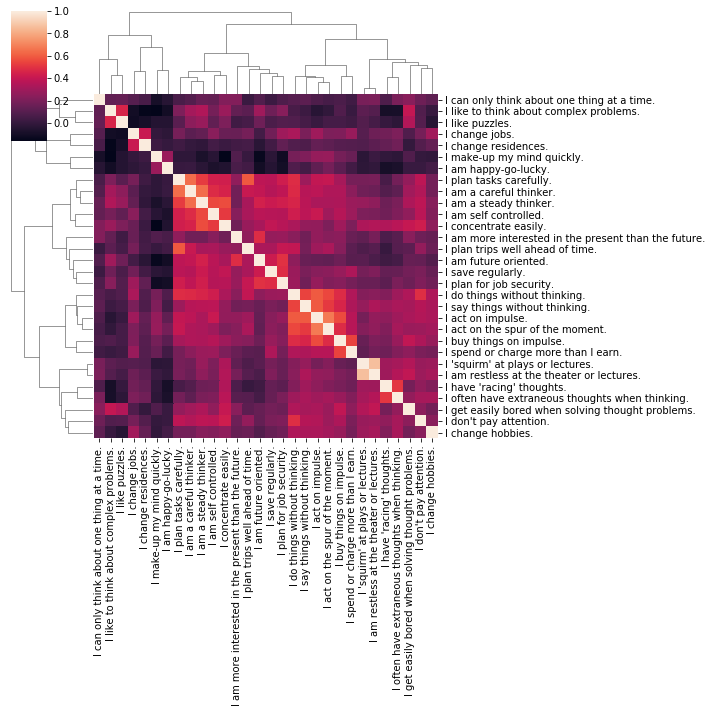

In [7]:
# Compute the correlation matrix across pairs items
cc = BIS11_itemdata.corr()

# display a cluster map

sns.clustermap(cc, method='ward')

Let's look at the split-half reliability of these items.  The basic idea is as follows:

- split the data into two sets of a particular size (randomly)
- assess the correlation between the splits


In [8]:
#here's a very simple implementation of split-half reliability
#this is a NON-boostrapping version

def get_correlation(data_by_trial, num_trials=None, 
                    num_splits=1000, random_seed=0,
                    statfunc=None):
    """arguments:
          data_by_trial (numpy array): the data
             assumes a tensor with structure is (observation units, trials)
             - e.g. (subjects, trials), or (items, trials)
             
          num_trials(nonnegative integer): how many trials to consider (None for all)
          
          num_splits (nonnegative integer): how many splits of the data to make

          random_seed (nonnegative integer): seed to use for random number generation (None for time-based seed)
          
          statfunc: (function): an arbitrary statistical function that returns a scalar (None for pearson r)
          
       returns:
          array of length num_splits
    """

    # if it's a pandas data frame then convert to numpy array
    if isinstance(data_by_trial, pd.DataFrame):
        data_by_trial = data_by_trial.values

    #get total number of trials
    num_total_trials = data_by_trial.shape[1]
    
    if num_trials is None:
        num_trials = num_total_trials

    #you better not ask for more trials than you actually have
    assert num_trials <= num_total_trials,\
        "You asked for %d trials but there's only %d" % (num_trials, num_total_trials)
    
    #we want to make sure that while we select groups of trials basically randomly,
    #that we can still exactly reproduce our results later
    #so to do this, we use a constructed random number generator to select trial groups
    #and seed the generator with seed = 0 (could be any non-negative integer, but the seed
    #*must* be set for this to be reproducible
    random_number_generator = np.random.RandomState(seed=random_seed)

    corrvals = []
    for split_index in range(num_splits):
        #construct a new permutation of the trial indices
        perm =  random_number_generator.permutation(num_total_trials)
    
        #take the first num_trials/2 and second num_trials/2 pieces of the data
        first_half_of_trial_indices = perm[:int(num_trials / 2)]
        second_half_of_trial_indices = perm[int(num_trials / 2): num_trials]
        
        #mean over trial dimension
        mean_first_half_of_trials = data_by_trial[
            :, first_half_of_trial_indices].mean(axis=1)

        mean_second_half_of_trials = data_by_trial[
            :, second_half_of_trial_indices].mean(axis=1)
        
        #compute the correlation between the means
        if statfunc is None:
            corrval = stats.pearsonr(mean_first_half_of_trials, 
                                 mean_second_half_of_trials)[0]
        else:
            corrval = statfunc(mean_first_half_of_trials, 
                                 mean_second_half_of_trials)
        #add to the list
        corrvals.append(corrval)
        
    return np.array(corrvals)

In [9]:
corrvals = get_correlation(BIS11_itemdata)
np.mean(corrvals)

0.7943460948445455

Here we are using all of the items, but we can also see what happens when we only use a subset of items. 

In [10]:
split_half_by_num_trials = pd.DataFrame(
    {'ntrials': [i for i in range(4, 31, 2)]})


for idx in split_half_by_num_trials.index:
    corrs = get_correlation(BIS11_itemdata,
                            split_half_by_num_trials.loc[idx, 'ntrials'])
    split_half_by_num_trials.loc[idx, 'meancorr'] = np.mean(corrs)
    

In [49]:
split_half_by_num_trials

,ntrials,meancorr
0,4,0.322581
1,6,0.430054
2,8,0.500645
3,10,0.558360
4,12,0.602040
5,14,0.639632
6,16,0.669176
7,18,0.696404
8,20,0.717937
9,22,0.737144


Text(0, 0.5, 'Reliability')

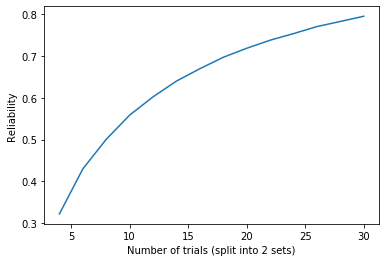

In [11]:
plt.plot(split_half_by_num_trials.ntrials, split_half_by_num_trials.meancorr)
plt.xlabel('Number of trials (split into 2 sets)')
plt.ylabel('Reliability')


### The prophecy formula

This relation between the number of measurements and reliability follows a lawful relationship, known as the *Spearman-Brown prophecy* formula:

$$
\rho_k = \frac{k * \rho}{1 + (k-1)*\rho}
$$

where $\rho$ is the reliability obtained for a particular number of trials $t$, and $k$ is the multiple of $t$ for which you wish to determine the estimated reliability.

Here let's take the mean reliability estimated for a total of 4 items, and use it to extrapolate the reliability for larger item sets.


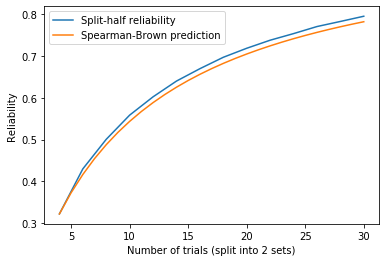

In [12]:
def get_spearman_brown(rho, k):
    """
    return Spearman-Brown prophecy value
    
    Parameters:
    ----------
    rho: scalar, correlation that is basis for prediction
    k: multiple of # of trials with which rho is computed
    """
    return((k*rho)/(1 + (k-1)*rho))

base_ntrials=4  # which row in 
rho = split_half_by_num_trials.query(f'ntrials == {base_ntrials}').loc[0, 'meancorr']

spearman_brown = pd.DataFrame({'nitems': np.arange(4, 31)})

for idx in spearman_brown.index:
    k = spearman_brown.loc[idx, 'nitems']/base_ntrials
    spearman_brown.loc[idx, 'sb'] = get_spearman_brown(rho, k)
    
plt.plot(split_half_by_num_trials.ntrials, split_half_by_num_trials.meancorr)
plt.plot(spearman_brown.nitems, spearman_brown.sb)
plt.xlabel('Number of trials (split into 2 sets)')
plt.ylabel('Reliability')
plt.legend(['Split-half reliability', 'Spearman-Brown prediction'])

### Internal consistency

Another related approach often used in psychology is to assess the overall consistency of responses between pairs of items, often referred to as *internal consistency*.  A commonly used metric for internal consistency is *Chronbach's alpha*. A standardized version of it can be computed as follows:

$$
\alpha_{standardized} = \frac{K * \bar{r}}{1 + (K - 1) * \bar{r}}
$$

where $K$ is the number of items on the test, and $\bar{r}$ is the average correlation between all items.  (You may notice that this is exactly the prophecy formula, plugging in the mean correlation for rho and the number of items for K).  We can compute this directly from the correlation matrix between items:


In [65]:
corrmtx = np.corrcoef(BIS11_itemdata.T)
mean_r = np.mean(corrmtx[np.triu_indices_from(corrmtx,1)])
K = BIS11_itemdata.shape[1]
alpha = (K*mean_r) / (1 + (K-1)*mean_r)
print(f'alpha: {alpha}')

# compare to split-half after correcting for number of items using spearman-brown
print(f'corrected split-half:{get_spearman_brown(split_half_by_num_trials.meancorr.iloc[-1], 2)}')

alpha: 0.8875056727687484
corrected split-half:0.8853878269379958


## Reliability in psychometrics

Within psychometrics, there is a tradition of thinking of reliability in terms of the relationship between an observed (or "manifest") variable, and the value of an underlying (or "latent") variable that gives rise to the observed value in combination with some degree of measurement error. 

This is often conceptualized in terms of a *path diagram*, in which arrows reflect influences from the latent variables (shows as ellipses or circles) to the measured variables (shown as boxes).  We will see this in more detail later when we discuss structural equation modeling.

Let's say that we have data from four different measures, of which two are measures of one latent variable (impulsivity) and the other two are measures of another latent variable (impatience).  Here is a path diagram for these variables (To see the code that generated it, look at PathDiagramExample.Rmd in this directory):


![title](path_diagram.png)

In this section we will work with simulated data, so that we know the true underlying scores for each individual. Let's generate some data from this model. We will treat the latent variables as normally distributed, with some degree of correlation.

In [13]:
def make_data(n_subjects=500,
              corr=0.5,
              error_var=0.5,
              scale_data=True,
              latent_seed=None,
              betavals=None):
    """
    create observed measurements from latent variables
    
    Parameters:
    ------------
    n_subjects: int, number of observations
    corr: float, population correlation between latent variables
    error_var: float, rror variance
    scale_data: bool, should we scale the variables?
    latent_seed: int or None, if set, will generate the same latent values each time (with different noise)
    betavals: dict, beta values for pairs of latent and observed variables
    """
    
    # create latent variables - multivariate normal with specified correlation

    if latent_seed is not None:
        rng = np.random.RandomState(seed=latent_seed)

    latents = rng.multivariate_normal(mean=[0, 0], 
                                    cov=[[1, corr], [corr, 1]],
                                    size=n_subjects)
    if scale_data:
        latents = scale(latents)

    df = pd.DataFrame(latents, columns=['impulsivity', 'impatience'])

    # create matrix to project latents into observed

    beta = pd.DataFrame(np.zeros((2, 4)), 
                        columns=['BIS', 'UPPS-P', 'Kirby', 'Bickel'],
                        index=df.columns)
    if betavals is None:
        betavals = {('impulsivity', 'BIS'): 1,
                    ('impulsivity', 'UPPS-P'): 1,
                    ('impatience', 'Bickel'): 1,
                    ('impatience', 'Kirby'): 1}
    for b in betavals:
        beta.loc[b[0], b[1]] = betavals[b]

    # create measurement noise, assume all variables have equal noise
    rng = np.random.RandomState(seed=None) # ensure different noise each time
    measurement_noise = rng.multivariate_normal(
        mean=[0, 0, 0, 0], 
        cov=np.eye(4)*error_var,
        size=n_subjects)

    # create observed data
    observed = df.dot(beta) + measurement_noise

    if scale_data:
        observed = (observed - observed.mean(axis=0)) / observed.std(axis=0)

    df = result = pd.concat([df, observed], axis=1)

    return(df)

In [14]:
df = make_data(latent_seed=123345)
# generate a "retest" dataset using the same latents

df2 = make_data(latent_seed=123345)

df.head()

,impulsivity,impatience,BIS,UPPS-P,Kirby,Bickel
0,1.118017,0.448284,2.114806,1.461345,0.670568,0.655593
1,0.338058,1.071326,0.822310,-0.360849,1.054650,0.831797
2,0.959298,1.738913,1.372216,1.290670,1.468835,2.231803
3,-1.600353,-1.283437,-1.894713,-0.589456,-1.217293,0.713185
4,1.524102,-0.491539,1.877221,1.375407,-0.232150,0.122215


Let's plot a heatmap of the correlations between latent and observed values

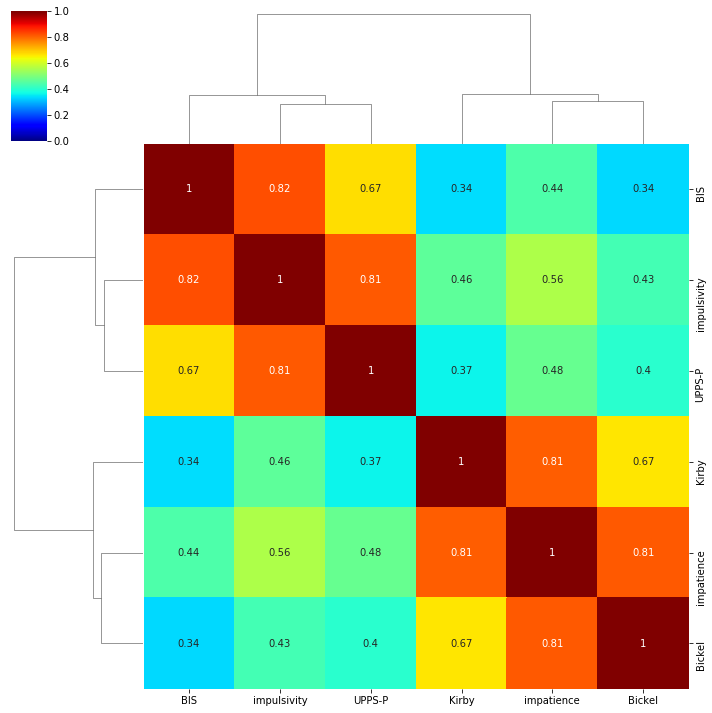

In [15]:
sns.clustermap(df.corr(), annot=True, vmin=0, cmap='jet')

What is the reliability of the measures for each latent?

In [16]:
rho_impulsivity = df[['BIS', 'UPPS-P']].corr().iloc[0, 1]
print('Impulsivity:', rho_impulsivity)

rho_impatience = df[['Kirby', 'Bickel']].corr().iloc[0, 1]
print('Impatience:', rho_impatience)

Impulsivity: 0.6736577790079828
Impatience: 0.6651636225574405


## Attenuation

Error variance in our measures will *attenuate* the correlation between measures.  In this example, let's say that we wanted to estimate the correlation between impulsivity and impatience using the BIS and Kirby measures.  In this case, we know the true correlations of the latent variables:

In [17]:
rho_impulsivity_impatience = df[['impulsivity', 'impatience']].corr().iloc[0, 1]
rho_impulsivity_impatience

0.5594926220293412

What do we see when we compare the two (noisy) measures?


In [18]:
rho_BIS_Kirby = df[['BIS', 'Kirby']].corr().iloc[0,1]
rho_BIS_Kirby

0.34192412355203505

The attenuation of the observed correlation for two measures $Y$ and $Y'$ of the same underlying construct follows the function:

$$
\rho_{Y, Y'} = \rho_{T_Y, T_{Y'}} * \sqrt{\rho_Y \rho_{Y'}}
$$


In [74]:
# first compute test-retest reliability for each measure
rho_BIS = np.corrcoef(df.BIS, df2.BIS)[0,1]
rho_Kirby = np.corrcoef(df.Kirby, df2.Kirby)[0,1]

# compute the predicted attenuated correlation
rho_BIS_Kirby_predicted = rho_impulsivity_impatience*np.sqrt(rho_Kirby*rho_BIS)
rho_BIS_Kirby_predicted

0.3779623961116336

We see here that the correlation between the measures is smaller than the correlation between their true scores, as predicted by the attenuation formula.  We can correct for this attenuation using Spearman's formula:

$$
\rho_{T_Y, T_{Y'}} = \frac{\rho_{Y, Y'}}{\sqrt{\rho_Y \rho_{Y'}}}
$$

That is, the observed correlation is attenuated by the square root of the product of the reliabilities of the individual variables. We can see this with our measures:

In [19]:
rho_BIS_Kirby_corrected = rho_BIS_Kirby / np.sqrt(rho_BIS * rho_Kirby)
rho_BIS_Kirby_corrected

0.5061456546717141

We see that this is much closer to the true correlation between the latent variables.

There is a flip side to this effect: The true correlation between two variables cannot exceed the product of the reliabilities of those measures. This became an issue in a paper published in 2009 titled [Puzzlingly High Correlations in fMRI Studies of Emotion, Personality, and Social Cognition](https://www.ncbi.nlm.nih.gov/pubmed/26158964) by Ed Vul and colleagues.  This paper pointed out that many fMRI studies had published correlations between brain and behavior that were well above 0.8, which was inconsistent with the known reliabilities of both fMRI signals and most behavioral measures.

## Test-retest reliability

We can also view test-retest reliability through the lens of classical test theory.

Let's compare this what we see if we were to collect a new dataset with the same latent variables but different noise:


In [20]:
df_retest = make_data(latent_seed=123345)

retest_correlations = pd.Series(index=['BIS', 'UPPS-P', 'Kirby', 'Bickel'], 
                                dtype=float)

for i in retest_correlations.index:
    retest_correlations[i] = np.corrcoef(df[i], df_retest[i])[0,1]

retest_correlations

BIS       0.647562
UPPS-P    0.647477
Kirby     0.628854
Bickel    0.692619
dtype: float64

These are very close to the reliabilities that we estimated above by comparing the two tests - unsurprisingly, since all of these were generated by simply adding the same kind of noise to the latents. 

In the former case we used Pearson correlation to compute the reliability.  The Pearson coefficient assesses the degree to which the variables are linearly related, but doesn't penalize for different means or slope other than one.  That it, it assesses how well the following model describes the data:

$$
y = slope * X + intercept
$$

In other cases, we might want to hold our measurements to a higher standard, such as $y = X$ (perfect agreement) or $y = X + intercept$ (consistency with a mean offset but $slope = 1$). The *intraclass correlation coefficient* is commonly used for this purpose. There are many different forms of the ICC - here we will focus on ICC(3,1), which is commonly used to assess retest reliability:

$$
ICC(3,1) = \frac{MS_{subjects} - MS_{error}}{MS_{subjects} + MS_{error}}
$$

for the specific version with two measurements for each subject.  

In [21]:
# adapted from https://github.com/nipy/nipype/blob/f2bbcc917899c98102bdeb84db61ea4b84cbf2f5/nipype/algorithms/icc.py#L29

def ICC_rep_anova(Y, verbose=True):
    '''
    the data Y are entered as a 'table' ie subjects are in rows and repeated
    measures in columns
    One Sample Repeated measure ANOVA
    Y = XB + E with X = [FaTor / Subjects]
    '''

    [nb_subjects, nb_conditions] = Y.shape
    dfc = nb_conditions - 1
    dfe = (nb_subjects - 1) * dfc
    dfr = nb_subjects - 1

    # Compute the repeated measure effect
    # ------------------------------------

    # Sum Square Total
    mean_Y = np.mean(Y)
    SST = ((Y - mean_Y)**2).sum()

    # create the design matrix for the different levels
    x = np.kron(np.eye(nb_conditions), np.ones((nb_subjects, 1)))  # sessions
    x0 = np.tile(np.eye(nb_subjects), (nb_conditions, 1))  # subjects
    X = np.hstack([x, x0])

    # Sum Square Error
    predicted_Y = np.dot(np.dot(np.dot(X, np.linalg.pinv(np.dot(X.T, X))), X.T), Y.flatten('F'))
    residuals = Y.flatten('F') - predicted_Y
    SSE = (residuals**2).sum()

    residuals.shape = Y.shape

    MSE = SSE / dfe

    # Sum square session effect - between colums/sessions
    SSC = ((np.mean(Y, 0) - mean_Y)**2).sum() * nb_subjects
    MSC = SSC / dfc / nb_subjects

    session_effect_F = MSC / MSE

    # Sum Square subject effect - between rows/subjects
    SSR = SST - SSC - SSE
    MSR = SSR / dfr

    # ICC(3,1) = (mean square subjeT - mean square error) /
    #            (mean square subjeT + (k-1)*-mean square error)
    ICC = (MSR - MSE) / (MSR + dfc * MSE)

    e_var = MSE  # variance of error
    r_var = (MSR - MSE) / nb_conditions  # variance between subjects
    if verbose:
        print('ICC:', ICC)
        print('r:', np.corrcoef(Y.T)[0, 1])
    return ICC

In [22]:
Y = pd.DataFrame({'orig': df['BIS'], 'retest': df_retest['BIS']})

_ = ICC_rep_anova(Y.values)

ICC: 0.6475622139702579
r: 0.6475622139702579


In this case we see that the ICC is exactly the same as the Pearson correlation, because the values have the same variance. However, because the ICC uses a pooled variance whereas the Pearson R scales separately by the variance of each variable, the ICC will differ if the variances differ:

In [23]:
Y['retest'] = Y['retest'] * 2

_ = ICC_rep_anova(Y.values)

ICC: 0.5180497711762065
r: 0.6475622139702579


The choice of when to use ICC versus Pearson's r depends on the interpretation that one wants.  If you simply care about the degree of shared variance without requiring that the measures share the same metric or variance, then Pearson's r is appropriate. However, depending on the nature of the dataset and the degree to which one wishes to assess different kinds of relationships between the tests (e.g. consistency vs. agreement), one might instead select the appropriate version of ICC.

For more, see:

McGraw, K. O., & Wong, S. P. (1996). Forming inferences about some intraclass correlation coefficients. Psychological Methods, 1(1), 30–46. doi:10.1037/1082-989x.1.1.30 


## Additional notes on reliability

In [46]:
import h5py
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [47]:
#ok let's load the data mb
DATA_PATH = "/mnt/data3/yamins/visual/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH, mode='r')

In [48]:
#useful utility function for plotting HDF5 dimension labels
def dimnames(dataset):
    dims = dataset.dims  #get the dimension object
    dimlist = [x.label for x in dims.keys()]  #get the label attribute
    dimlist = map(str, dimlist)  #cast everything to string instead of "unicode" ... complicated rathole ... not strictly necessary
    return dimlist

In [49]:
Ventral_Dataset.keys()

[u'image_meta',
 u'images',
 u'neural_meta',
 u'time_averaged',
 u'time_averaged_trial_averaged',
 u'time_binned',
 u'time_binned_trial_averaged']

In [50]:
Ventral_Dataset['time_averaged']

<HDF5 group "/time_averaged" (3 members)>

In [51]:
Ventral_Dataset['time_averaged'].keys()

[u'variation_level_0', u'variation_level_3', u'variation_level_6']

In [52]:
Ventral_Dataset['time_averaged']['variation_level_0']

<HDF5 dataset "variation_level_0": shape (28, 640, 296), type "<f4">

In [53]:
dimnames(Ventral_Dataset['time_averaged']['variation_level_0'])

['trial', 'image', 'neuron']

In [54]:
#these are indices into the neurons dimension, defining different subsets of neurons
#in different brain areas
V4_NEURONS = Ventral_Dataset['neural_meta']['V4_NEURONS'][:]
print(V4_NEURONS)
print('\nThere are %d V4 neurons' % len(V4_NEURONS))

IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS'][:]
print(IT_NEURONS)
print('\n There are %d IT neurons' % len(IT_NEURONS))

[ 11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28
  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 163 164
 165 166 167 168 169 170 211 212 213 214 215 216 217 218 219 220 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295]

There are 128 V4 neurons
[  0   1   2   3   4   5   6   7   8   9  10  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 18

In [55]:
var_level = Ventral_Dataset['image_meta']['variation_level'][:]
unique_var_levels = np.unique(var_level)
unique_var_levels

array(['V0', 'V3', 'V6'], dtype='|S2')

In [66]:
#wrap the data into a useful bject for our purposes (reliability analysis)

IT_Data_by_trial = {}
for vl in unique_var_levels:
    level_number = int(vl[-1])
    arr = Ventral_Dataset['time_averaged']['variation_level_%s' % level_number][:, :, IT_NEURONS]
    IT_Data_by_trial[vl] = arr.swapaxes(0, 1)

In [67]:
#num_images by num_trials by num_neurons
IT_Data_by_trial['V6'].shape

(2560, 47, 168)

In [68]:
#here's a very simple implementation of split-half reliability

def get_correlation(data_by_trial, num_trials, num_splits):
    """arguments:
          data_by_trial -- (numpy array) the data
             assumes a tensor with structure is (conditions, trials)
             
          num_trials -- (nonnegative integer) how many trials to consider
          
          num_splits (nonnegative integer) how many splits of the data to make
          
       returns:
          array of length num_splits
    """

    
    #get total number of trials
    num_total_trials = data_by_trial.shape[1]
    
    #you better not ask for more trials than you actually have
    assert num_trials <= num_total_trials, "You asked for %d trials but there's only %d" % (num_trials, num_total_trials)
    
    #we want to make sure that while we select groups of trials basically randomly,
    #that we can still exactly reproduce our results later
    #so to do this, we use a constructed random number generator to select trial groups
    #and seed the generator with seed = 0 (could be any non-negative integer, but the seed
    #*must* be set for this to be reproducible
    random_number_generator = np.random.RandomState(seed=0)

    corrvals = []
    for split_index in range(num_splits):
        #construct a new permutation of the trial indices
        perm =  random_number_generator.permutation(num_total_trials)
    
        #take the first num_trials/2 and second num_trials/2 pieces of the data
        first_half_of_trial_indices = perm[:int(num_trials / 2)]
        second_half_of_trial_indices = perm[int(num_trials / 2): num_trials]
        
        #mean over trial dimension
        mean_first_half_of_trials = data_by_trial[:, first_half_of_trial_indices].mean(axis=1)
        mean_second_half_of_trials = data_by_trial[:, second_half_of_trial_indices].mean(axis=1)
        
        #compute the correlation between the means
        corrval = stats.pearsonr(mean_first_half_of_trials, 
                                 mean_second_half_of_trials)[0]
        #add to the list
        corrvals.append(corrval)
        
    return np.array(corrvals)

(-1, 513)

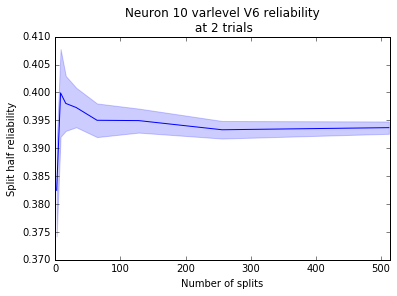

In [71]:
#in fact, let's plot reliability estimate and the SEM as 
#a function of the number of splits
#... first for 10 trials

neuron_ind = 10
vl = 'V6'

num_trials = 2

means = []
sems = []

num_splits = [2, 8, 16, 32, 64, 128, 256, 512]
for ns in num_splits:
    cs = get_correlation(IT_Data_by_trial[vl][:, :, neuron_ind],
                           num_trials, 
                           ns)
    mean = cs.mean()
    means.append(mean)
    sem = cs.std() / np.sqrt(ns)
    sems.append(sem)
    
means = np.array(means)
sems = np.array(sems)

plt.plot(num_splits, means)
plt.fill_between(num_splits, means - sems, means + sems, color='b', alpha = 0.2)
plt.xlabel('Number of splits')
plt.ylabel('Split half reliability')
plt.title('Neuron %d varlevel %s reliability\n at %d trials' % (neuron_ind, vl, num_trials))
plt.xlim(-1, 513)

(-1, 513)

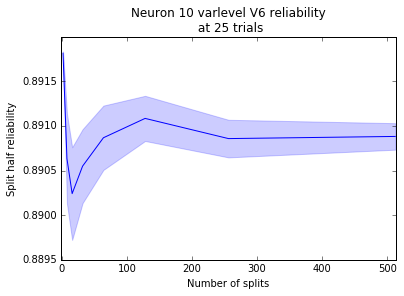

In [72]:
#... now for 25 trials
neuron_ind = 10
vl = b'V6'

num_trials = 25

means = []
sems = []

num_splits = [2, 8, 16, 32, 64, 128, 256, 512]
for ns in num_splits:
    cs = get_correlation(IT_Data_by_trial[vl][:, :, neuron_ind], 
                         num_trials, 
                         ns)
    mean = cs.mean()
    means.append(mean)
    sem = cs.std() / np.sqrt(ns)
    sems.append(sem)
    
means = np.array(means)
sems = np.array(sems)

plt.plot(num_splits, means)
plt.fill_between(num_splits, means - sems, means + sems, color='b', alpha = 0.2)
plt.xlabel('Number of splits')
plt.ylabel('Split half reliability')
plt.title('Neuron %d varlevel %s reliability\n at %d trials' % (neuron_ind, vl, num_trials))
plt.xlim(-1, 513)

#conclusion:  it looks like having num_splits ~ 10 * num_trials is good enough

In [73]:
#ok so now let's look at reliability as a function of number of trials

def get_reliability_curve(data):
    """
    This is a convenience function that plots reliability as a function of number of trials for some data
    
    arguments:
       data -- (numpy array) of shape (stimuli, trials)
    
    """
    means = []
    sems = []
    
    #determine the total number of trials
    total_num_trials = data.shape[1]
    
    #we'll evaluate reliability for each number of trials betwee 2 and the total
    num_trials = range(2, total_num_trials)
    for nt in num_trials:
        ns = 10 * nt
        cs = get_correlation(data,
                               nt, 
                               ns)
        mean = cs.mean()
        means.append(mean)
        sem = cs.std() / np.sqrt(ns)
        sems.append(sem)
        
        multiple = total_num_trials / float(nt) #have to do "float" here since python 2.x does integer division
         
    means = np.array(means)
    sems = np.array(sems)
    
    ln = plt.plot(num_trials, means)[0]  #this "ln" thing is a matplotlib thing -- usefor for making legens (see below)
    plt.fill_between(num_trials, means - sems, means + sems, color='b', alpha = 0.2)
 
    plt.xlabel('Number of Trials')
    plt.ylabel('Mean correlation')
    
    return ln

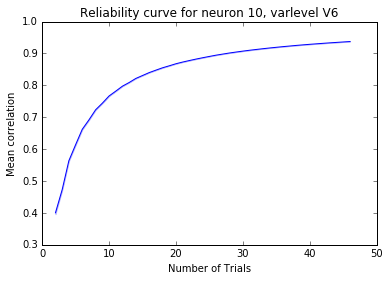

In [74]:
neuron_ind = 10
vl = b'V6'
get_reliability_curve(IT_Data_by_trial[vl][:, :, neuron_ind]);

ln = plt.title('Reliability curve for neuron %d, varlevel %s' % (neuron_ind, vl))

### spearman-brown correction

In [75]:
def spearman_brown(uncorrected, multiple):
    numerator = multiple * uncorrected
    denominator = 1 + (multiple - 1) * uncorrected
    return numerator / denominator

In [76]:
#ok so now let's look at reliability as a function of number of trials

def get_reliability_curve_spearman_brown(data):
    """
    This is a convenience function that plots reliability as a function of number of trials for some data
    
    arguments:
       data -- (numpy array) of shape (stimuli, trials)
    
    """
    means = []
    sems = []
    corrected_means = []

    #determine the total number of trials
    total_num_trials = data.shape[1]
    
    #we'll evaluate reliability for each number of trials betwee 2 and the total
    num_trials = range(2, total_num_trials)
    for nt in num_trials:
        ns = 10 * nt
        cs = get_correlation(data,
                               nt, 
                               ns)
        mean = cs.mean()
        means.append(mean)
        sem = cs.std() / np.sqrt(ns)
        sems.append(sem)
        
        multiple = total_num_trials / float(nt) #have to do "float" here since python 2.x does integer division
        corrected_mean = spearman_brown(mean, multiple) 
        corrected_means.append(corrected_mean)
        
    means = np.array(means)
    sems = np.array(sems)
    corrected_means = np.array(corrected_means)
    
    ln = plt.plot(num_trials, means)[0]  #this "ln" thing is a matplotlib thing -- usefor for making legens (see below)
    plt.fill_between(num_trials, means - sems, means + sems, color='b', alpha = 0.2)
    
    ln_cor = plt.plot(num_trials, corrected_means)[0]

    plt.xlabel('Number of Trials')
    plt.ylabel('Mean correlation')
    
    return (ln, ln_cor)

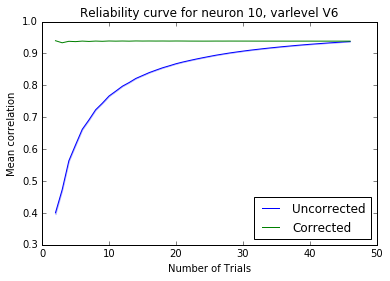

In [77]:
#ok the spearman-brown correction is a little bit of an overestimate here ...
#... but not bad
neuron_ind = 10
vl = b'V6'
ln, ln_cor = get_reliability_curve_spearman_brown(IT_Data_by_trial[vl][:, :, neuron_ind]);

plt.title('Reliability curve for neuron %d, varlevel %s' % (neuron_ind, vl))

plt.legend([ln, ln_cor], ['Uncorrected', 'Corrected'], loc='lower right')

